In [ ]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

In [ ]:
from keras.datasets import cifar10
from keras.models import Sequential, Model
from keras.layers import Input, Dense, LeakyReLU, BatchNormalization, ReLU
from keras.layers import Conv2D, Conv2DTranspose, Reshape, Flatten
from tensorflow.keras.optimizers import Adam
from keras import initializers

from tensorflow.keras.utils import plot_model
from keras.utils import np_utils
from keras import backend as K

In [ ]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

170508288/170498071 [==============================] - 11s 0us/step


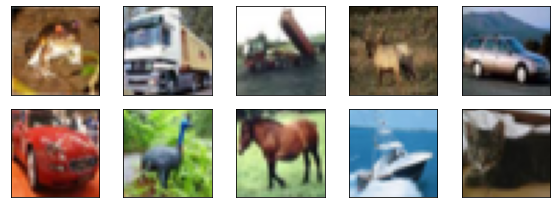

In [ ]:
fig = plt.figure(figsize=(8,3))
for i in range(0, 10):
    plt.subplot(2, 5, 1 + i, xticks=[], yticks=[])
    plt.imshow(X_train[i])
    
plt.tight_layout()

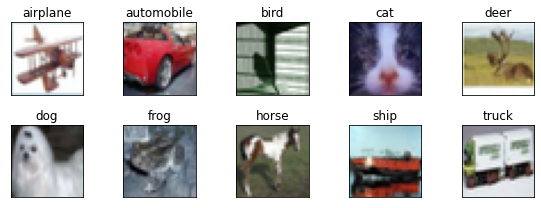

In [ ]:
num_classes = len(np.unique(y_train))
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = plt.subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(y_train[:]==i)[0]
    features_idx = X_train[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    img = features_idx[img_num,::]
    ax.set_title(class_names[i])
    plt.imshow(img)
    
plt.tight_layout()

In [ ]:
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

X_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [ ]:
if K.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 3, 32, 32)
    X_test = X_test.reshape(X_test.shape[0], 3, 32, 32)
    input_shape = (3, 32, 32)
else:
    X_train = X_train.reshape(X_train.shape[0], 32, 32, 3)
    X_test = X_test.reshape(X_test.shape[0], 32, 32, 3)
    input_shape = (32, 32, 3)
    
# convert class vectors to binary class matrices
Y_train = np_utils.to_categorical(y_train, num_classes)
Y_test = np_utils.to_categorical(y_test, num_classes)

# the generator is using tanh activation, for which we need to preprocess 
# the image data into the range between -1 and 1.

X_train = np.float32(X_train)
X_train = (X_train / 255 - 0.5) * 2
X_train = np.clip(X_train, -1, 1)

X_test = np.float32(X_test)
X_test = (X_train / 255 - 0.5) * 2
X_test = np.clip(X_test, -1, 1)

print('X_train reshape:', X_train.shape)
print('X_test reshape:', X_test.shape)

X_train reshape: (50000, 32, 32, 3)
X_test reshape: (50000, 32, 32, 3)


In [ ]:
latent_dim = 100

init = initializers.RandomNormal(stddev=0.02)

# Generator network
generator = Sequential()

# FC: 2x2x512
generator.add(Dense(2*2*512, input_shape=(latent_dim,), kernel_initializer=init))
generator.add(Reshape((2, 2, 512)))
generator.add(BatchNormalization())
generator.add(LeakyReLU(0.2))

# # Conv 1: 4x4x256
generator.add(Conv2DTranspose(256, kernel_size=5, strides=2, padding='same'))
generator.add(BatchNormalization())
generator.add(LeakyReLU(0.2))

# Conv 2: 8x8x128
generator.add(Conv2DTranspose(128, kernel_size=5, strides=2, padding='same'))
generator.add(BatchNormalization())
generator.add(LeakyReLU(0.2))

# Conv 3: 16x16x64
generator.add(Conv2DTranspose(64, kernel_size=5, strides=2, padding='same'))
generator.add(BatchNormalization())
generator.add(LeakyReLU(0.2))

# Conv 4: 32x32x3
generator.add(Conv2DTranspose(3, kernel_size=5, strides=2, padding='same',
                              activation='tanh'))

In [ ]:
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 2048)              206848    
                                                                 
 reshape (Reshape)           (None, 2, 2, 512)         0         
                                                                 
 batch_normalization (BatchN  (None, 2, 2, 512)        2048      
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 2, 2, 512)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 4, 4, 256)        3277056   
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 4, 4, 256)        1

In [ ]:
img_shape = X_train[0].shape

# Discriminator network
discriminator = Sequential()

# Conv 1: 16x16x64
discriminator.add(Conv2D(64, kernel_size=5, strides=2, padding='same',
                         input_shape=(img_shape), kernel_initializer=init))
discriminator.add(LeakyReLU(0.2))

# Conv 2:
discriminator.add(Conv2D(128, kernel_size=5, strides=2, padding='same'))
discriminator.add(BatchNormalization())
discriminator.add(LeakyReLU(0.2))

# Conv 3: 
discriminator.add(Conv2D(256, kernel_size=5, strides=2, padding='same'))
discriminator.add(BatchNormalization())
discriminator.add(LeakyReLU(0.2))

# Conv 3: 
discriminator.add(Conv2D(512, kernel_size=5, strides=2, padding='same'))
discriminator.add(BatchNormalization())
discriminator.add(LeakyReLU(0.2))

# FC
discriminator.add(Flatten())

# Output
discriminator.add(Dense(1, activation='sigmoid'))

In [ ]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 16, 16, 64)        4864      
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 16, 16, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 128)         204928    
                                                                 
 batch_normalization_4 (Batc  (None, 8, 8, 128)        512       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 256)         819456    
                                                      

In [ ]:
discriminator.compile(Adam(lr=0.0003, beta_1=0.5), loss='binary_crossentropy',
                      metrics=['binary_accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
discriminator.trainable = False

z = Input(shape=(latent_dim,))
img = generator(z)
decision = discriminator(img)
d_g = Model(inputs=z, outputs=decision)

d_g.compile(Adam(lr=0.0004, beta_1=0.5), loss='binary_crossentropy',
            metrics=['binary_accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
d_g.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 sequential (Sequential)     (None, 32, 32, 3)         4516739   
                                                                 
 sequential_1 (Sequential)   (None, 1)                 4312193   
                                                                 
Total params: 8,828,932
Trainable params: 4,514,819
Non-trainable params: 4,314,113
_________________________________________________________________


epoch = 1/100, d_loss=0.165, g_loss=0.041                                                                                                     


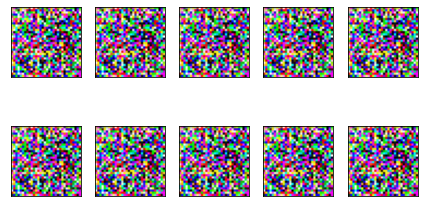

epoch = 2/100, d_loss=0.165, g_loss=0.113                                                                                                     
epoch = 3/100, d_loss=0.163, g_loss=0.111                                                                                                     
epoch = 4/100, d_loss=0.163, g_loss=0.137                                                                                                     
epoch = 5/100, d_loss=0.163, g_loss=0.115                                                                                                     
epoch = 6/100, d_loss=0.163, g_loss=0.179                                                                                                     
epoch = 7/100, d_loss=0.163, g_loss=0.195                                                                                                     
epoch = 8/100, d_loss=0.164, g_loss=0.136                                                                                                     

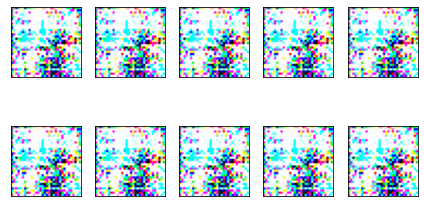

epoch = 12/100, d_loss=0.163, g_loss=0.247                                                                                                     
epoch = 13/100, d_loss=0.163, g_loss=0.198                                                                                                     
epoch = 14/100, d_loss=0.163, g_loss=0.190                                                                                                     
epoch = 15/100, d_loss=0.163, g_loss=0.248                                                                                                     
epoch = 16/100, d_loss=0.163, g_loss=0.219                                                                                                     
epoch = 17/100, d_loss=0.163, g_loss=0.231                                                                                                     
epoch = 18/100, d_loss=0.163, g_loss=0.262                                                                                              

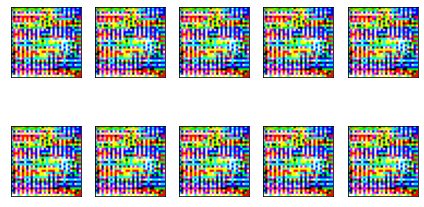

epoch = 22/100, d_loss=0.163, g_loss=0.459                                                                                                     
epoch = 23/100, d_loss=0.163, g_loss=0.367                                                                                                     
epoch = 24/100, d_loss=0.163, g_loss=0.318                                                                                                     
epoch = 25/100, d_loss=0.163, g_loss=0.391                                                                                                     
epoch = 26/100, d_loss=0.163, g_loss=0.356                                                                                                     
epoch = 27/100, d_loss=0.163, g_loss=0.304                                                                                                     
epoch = 28/100, d_loss=0.163, g_loss=0.334                                                                                              

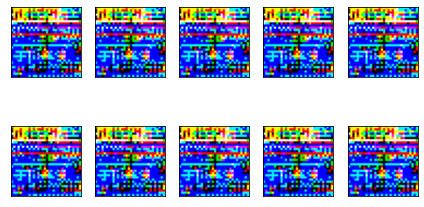

epoch = 32/100, d_loss=0.163, g_loss=0.257                                                                                                     
epoch = 33/100, d_loss=0.163, g_loss=0.255                                                                                                     
epoch = 34/100, d_loss=0.163, g_loss=0.304                                                                                                     
epoch = 35/100, d_loss=0.163, g_loss=0.300                                                                                                     
epoch = 36/100, d_loss=0.163, g_loss=0.295                                                                                                     
epoch = 37/100, d_loss=0.163, g_loss=0.290                                                                                                     
epoch = 38/100, d_loss=0.163, g_loss=0.265                                                                                              

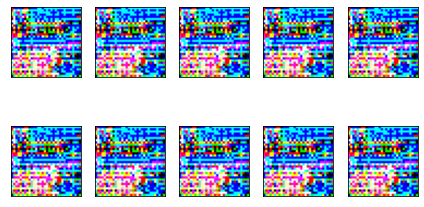

epoch = 42/100, d_loss=0.163, g_loss=0.256                                                                                                     
epoch = 43/100, d_loss=0.163, g_loss=0.242                                                                                                     
epoch = 44/100, d_loss=0.163, g_loss=0.243                                                                                                     
epoch = 45/100, d_loss=0.163, g_loss=0.247                                                                                                     
epoch = 46/100, d_loss=0.163, g_loss=0.249                                                                                                     
epoch = 47/100, d_loss=0.163, g_loss=0.242                                                                                                     
epoch = 48/100, d_loss=0.163, g_loss=0.249                                                                                              

In [ ]:
epochs = 100
batch_size = 32
smooth = 0.1

real = np.ones(shape=(batch_size, 1))
fake = np.zeros(shape=(batch_size, 1))

d_loss = []
g_loss = []

for e in range(epochs + 1):
    for i in range(len(X_train) // batch_size):
        
        # Train Discriminator weights
        discriminator.trainable = True
        
        # Real samples
        X_batch = X_train[i*batch_size:(i+1)*batch_size]
        d_loss_real = discriminator.train_on_batch(x=X_batch,
                                                   y=real * (1 - smooth))
        
        # Fake Samples
        z = np.random.normal(loc=0, scale=1, size=(batch_size, latent_dim))
        X_fake = generator.predict_on_batch(z)
        d_loss_fake = discriminator.train_on_batch(x=X_fake, y=fake)
         
        # Discriminator loss
        d_loss_batch = 0.5 * (d_loss_real[0] + d_loss_fake[0])
        
        # Train Generator weights
        discriminator.trainable = False
        g_loss_batch = d_g.train_on_batch(x=z, y=real)

        print(
            'epoch = %d/%d, batch = %d/%d, d_loss=%.3f, g_loss=%.3f' % (e + 1, epochs, i, len(X_train) // batch_size, d_loss_batch, g_loss_batch[0]),
            100*' ',
            end='\r'
        )
    
    d_loss.append(d_loss_batch)
    g_loss.append(g_loss_batch[0])
    print('epoch = %d/%d, d_loss=%.3f, g_loss=%.3f' % (e + 1, epochs, d_loss[-1], g_loss[-1]), 100*' ')

    if e % 10 == 0:
        samples = 10
        x_fake = generator.predict(np.random.normal(loc=0, scale=1, size=(samples, latent_dim)))

        for k in range(samples):
            plt.subplot(2, 5, k + 1, xticks=[], yticks=[])
            plt.imshow(((x_fake[k] + 1)* 127).astype(np.uint8))

        plt.tight_layout()
        plt.show()